In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display

In [ ]:

cwd = os.getcwd()
os.chdir(cwd)
print(os.listdir("../input"))

['celeba-dataset']


In [ ]:
path_celeb = []
train_path_celeb = "/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/"
for path in os.listdir(train_path_celeb):
    if '.jpg' in path:
        path_celeb.append(os.path.join(train_path_celeb, path))

In [ ]:
new_path=path_celeb[0:50000]

In [ ]:
len(new_path)

50000

In [ ]:
from PIL import Image
from keras import preprocessing
from keras.models import Sequential
from keras.layers import Conv2D,Dropout,Dense,Flatten,Conv2DTranspose,BatchNormalization,LeakyReLU,Reshape
import tensorflow as tf


###  Image Preprocessing

- **Crop**: Extracts the central face `(30, 55, 150, 175)`.  
- **Convert & Resize**: Converts to grayscale (`L`) and resizes to `64x64`.  
- **Tensor (GPU)**: Converts to PyTorch tensor `(1,1,64,64)` and moves to GPU.  
- **Normalize**: Scales pixels to `[0,1]` (or `[-1,1]` if using `tanh`).  
- **Back to NumPy**: Converts back for inspection/saving.  

 Prepares clean, normalized face images for GAN training.  


In [ ]:
import torch
from PIL import Image
import numpy as np
from tqdm import tqdm

crop = (30, 55, 150, 175)
images = [np.array((Image.open(path).crop(crop).convert("L")).resize((64, 64))) for path in new_path]

images_tensor = [torch.tensor(image).float().unsqueeze(0).unsqueeze(0).cuda() for image in images]

for i in tqdm(range(len(images_tensor)), desc="Processing images"):
    images_tensor[i] = (images_tensor[i] - images_tensor[i].min()) / (255 - images_tensor[i].min())
images = [img.cpu().numpy().squeeze() for img in images_tensor]

Processing images: 100%|██████████| 50000/50000 [00:03<00:00, 16485.90it/s]


In [ ]:
# from tqdm import tqdm

# crop = (30, 55, 150, 175)  # cropping size for the image so that only the face at center is obtained
# images = [np.array((Image.open(path).crop(crop).convert("L")).resize((64, 64))) for path in new_path]

# # Use tqdm to monitor the progress
# for i in tqdm(range(len(images)), desc="Processing images"):
#     images[i] = ((images[i] - images[i].min()) / (255 - images[i].min()))
#     # images[i] = images[i] * 2 - 1  # uncomment this if activation is tanh for generator last layer

# images = np.array(images)


Processing images: 100%|██████████| 50000/50000 [00:01<00:00, 25613.31it/s]


In [ ]:
train_data=images

In [ ]:
print(train_data.shape)

(50000, 64, 64)


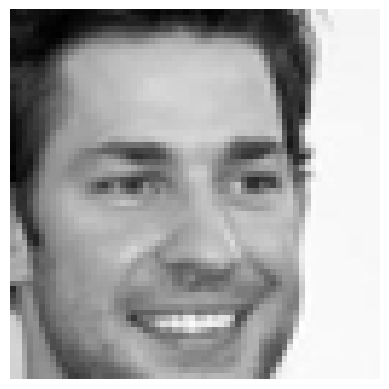

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(images[0], cmap="gray")
plt.axis("off")
plt.show()


In [ ]:
tf.__version__
tf.test.is_gpu_available()

True

###  Generator Model (GAN)

- **Input**: Random noise vector of size `100`.  
- **Dense Layer**: Projects noise → `8×8×256` feature map.  
- **Reshape**: Converts to 3D tensor `(8, 8, 256)`.  
- **Upsampling (Conv2DTranspose)**:  
  - `128 filters → 16×16`  
  - `64 filters → 32×32`  
- **Final Layer**: `1 filter (tanh)` → outputs grayscale `64×64×1` image.  

 This generator progressively upsamples noise into a realistic image.  


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

def make_generator_model():

    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256)
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64, 64, 1)

    return model


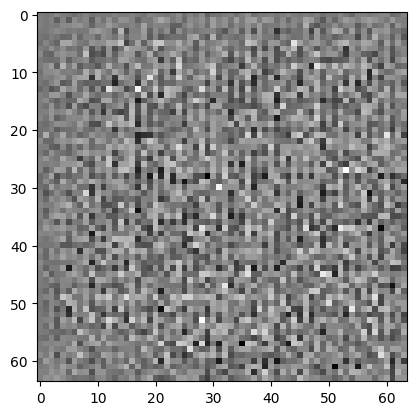

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

###  Discriminator Model (GAN)

- **Input**: `64×64×1` grayscale image.  
- **Conv Layers**:  
  - `64 filters → downsample to 32×32`  
  - `128 filters → downsample to 16×16`  
  - `256 filters → downsample to 8×8`  
- Each conv step uses **LeakyReLU + Dropout** for stability.  
- **Flatten + Dense(1)**: Outputs a single score (real vs fake).  

 The discriminator acts as a binary classifier to distinguish real images from generated ones.  


In [ ]:

def make_discriminator_model():

    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[64, 64, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


In [ ]:

discriminator = make_discriminator_model()
decision = discriminator(generated_image)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00074729]], dtype=float32)>

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

###  Discriminator Loss

- **Real Loss**: Compares real images to label `1` (real).  
- **Fake Loss**: Compares generated images to label `0` (fake).  
- **Total Loss** = `real_loss + fake_loss`.  

 The discriminator is penalized when it misclassifies real or fake images, ensuring it learns to separate them effectively.  


In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

###  Generator Loss

- **Goal**: Fool the discriminator.  
- **Loss**: Compares generated (fake) outputs to label `1` (real).  
- If the discriminator thinks fakes are real → generator succeeds.  

 Encourages the generator to produce images that look realistic.  


In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

###  Optimizers

- Both **Generator** and **Discriminator** use **Adam optimizer**.  
- **Learning rate** = `1e-4` (small for stable GAN training).  
- Adam helps balance convergence speed and stability during adversarial training.  

 Ensures both networks learn effectively without overpowering each other.  


In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

###  Training Step (One Batch)

- **Noise Input**: Sample random noise → feed into generator.  
- **Generated Images**: Created by the generator.  
- **Discriminator Outputs**:  
  - On real images → `real_output`  
  - On generated images → `fake_output`  
- **Losses**:  
  - `gen_loss`: how well generator fooled discriminator.  
  - `disc_loss`: how well discriminator separated real vs fake.  
- **Gradients**: Compute w.r.t generator & discriminator.  
- **Update**: Apply Adam optimizer to both networks.  

 This function performs one training step of the GAN.  


In [ ]:

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

###  Checkpoint System

- **Directory**: `./training_checkpoints` stores saved models.  
- **Checkpoint**: Saves state of  
  - Generator  
  - Discriminator  
  - Their optimizers  
- **Usage**: Allows resuming training or restoring the best model later.  

 Ensures training progress isn’t lost and models can be reused.  


In [ ]:

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = checkpoint_dir + "/ckpt"
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


###  Training Loop

- **Epoch Loop**: Runs for the specified number of epochs.  
- **Batch Training**: Calls `train_step()` for each batch.  
- **Image Generation**: Saves sample outputs each epoch to monitor progress.  
- **Checkpointing**: Saves model every 15 epochs.  
- **Timing**: Prints duration per epoch.  
- **Final Output**: Generates and displays images after the last epoch.  

 This loop orchestrates GAN training and progress visualization.  


In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    for image_batch in dataset:
      train_step(image_batch)
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):

  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:

BATCH_SIZE = 256
train_images = np.expand_dims(train_data, axis=-1)
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).batch(BATCH_SIZE)



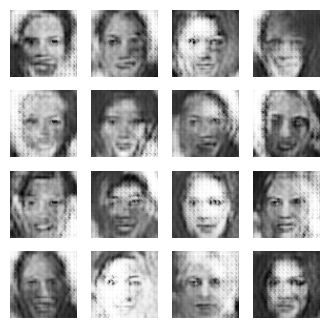

In [ ]:
train(train_dataset, EPOCHS)


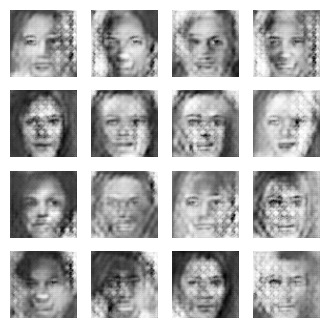

In [ ]:

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir)).expect_partial()


def test_generator(model, num_images=16):
    noise = tf.random.normal([num_images, noise_dim])
    predictions = model(noise, training=False)

    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :, 0] * 127.5 + 127.5).numpy().astype("uint8"), cmap="gray")
        plt.axis("off")

    plt.show()

test_generator(generator, num_images=16)


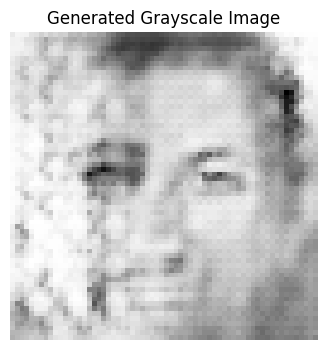

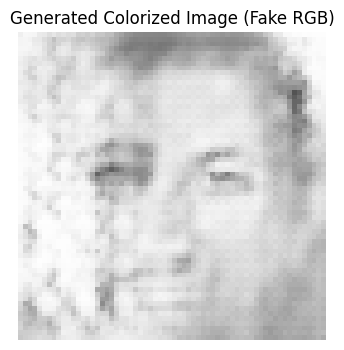

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir)).expect_partial()


def generate_single_image(model, noise_dim=100):

    noise = tf.random.normal([1, noise_dim])
    prediction = model(noise, training=False)


    image = (prediction[0, :, :, 0] * 127.5 + 127.5).numpy().astype("uint8")


    plt.figure(figsize=(4,4))
    plt.imshow(image, cmap="gray")
    plt.title("Generated Grayscale Image")
    plt.axis("off")
    plt.show()


    image_rgb = np.stack([image]*3, axis=-1)


    plt.figure(figsize=(4,4))
    plt.imshow(image_rgb)
    plt.title("Generated Colorized Image (Fake RGB)")
    plt.axis("off")
    plt.show()

    return image, image_rgb

gray_img, color_img = generate_single_image(generator)
